# Hotel Booking Cancellation Project

The primary job of a hotel, and many other companies, is to provide their services to customers who book to be provided with such service. However, it is all too common for "customers" who book reservations in advance to cancel it. This has the ability to hurt the hotel, as although they can charge for some amount to people who cancel, it lowers potential profits. 

The Hotel Booking Cancellation Dataset provides 100,000+ instances of booking information, with 31 key features corresponding to each customer. Data Analysis can be preformed on the dataset to extract meaningful correlations between features and cancellation rates. Then, Machine Learning can be preformed to attempt to predict if a customer will cancel or not. 

In [5]:
#Import neccessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import pickle
from scipy import stats
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
style.use('seaborn-poster')
style.use('fivethirtyeight')
print("Imported modules!")

Imported modules!


In [2]:
#Read and extract info off dataset

df = pd.read_csv('hotel_bookings.csv')
print(df.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

# Data Analysis

Based on the dataset, we can use feature engineering and EDA to extract useful information about the hotels and their booking information. 

We can see that most columns do not have any NULL values, except for 4: Children, Country, Agent, and Company. Since Company consists of ~94% of NULLs, it can be removed. The rest of the columns can just be changed to include "Not Specified", except for the children column which can be combined with the babies column. 

As well as that, we can also combine stays_in_weekend_nights and stays_in_week_nights to stay_in_nights. 

In [3]:
#Combine children with babies into a minors column

df['children'] = df['children'].fillna(0)
df['minors'] = df['children'] + df['babies']
df = df.drop(['children', 'babies'], axis=1)

#Include a Not Specified Section for the 2 of the 4 NaN Containing Columns

df['country'] = df['country'].fillna('Not Specified')
df['agent'] = df['agent'].fillna('Not Specified')

#Combine stays_in_weekend_nights and stays_in_week_nights
df['stay_in_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df = df.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1)

#Remove the company column from the dataset

df = df.drop('company', axis=1)

print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
adults                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_date           0
minors                      

In [13]:
df_numeric = df.copy()

for col in df_numeric.columns:
    if df[col].dtype.name == 'object':
        df_numeric[col] = df_numeric[col].astype('category').cat.codes
        
print(len(df_numeric.columns))
print(df_numeric)

29
        hotel  is_canceled  lead_time  arrival_date_year  arrival_date_month  \
0           1            0        342               2015                   5   
1           1            0        737               2015                   5   
2           1            0          7               2015                   5   
3           1            0         13               2015                   5   
4           1            0         14               2015                   5   
...       ...          ...        ...                ...                 ...   
119385      0            0         23               2017                   1   
119386      0            0        102               2017                   1   
119387      0            0         34               2017                   1   
119388      0            0        109               2017                   1   
119389      0            0        205               2017                   1   

        arrival_date_week_number  ar

With the NaN values dealt with from the dataframe, EDA can begin. Before focusing on the correlations between various features, we can start by showcasing basic statistics about the customers within a hotel.

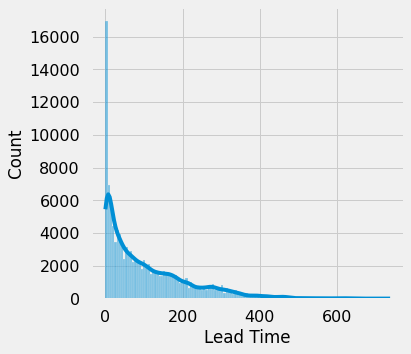

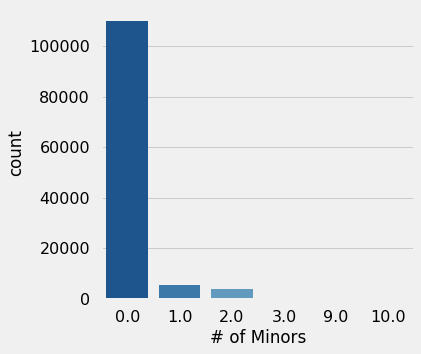

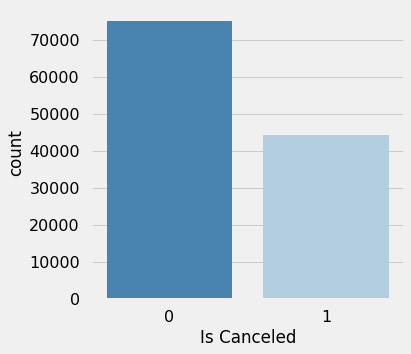

In [6]:
#Histogram of the lead time

plt.figure(figsize=(5,5))
sns.histplot(x='lead_time', kde=True, data=df)
plt.xlabel('Lead Time')
plt.show()

#Histogram of the number of minors

plt.figure(figsize=(5,5))
sns.countplot(x='minors', data=df, palette='Blues_r')
plt.xlabel('# of Minors')
plt.show()

#Count plot of the number of cancellations

plt.figure(figsize=(5,5))
sns.countplot(x='is_canceled', data=df, palette='Blues_r')
plt.xlabel('Is Canceled')
plt.show()

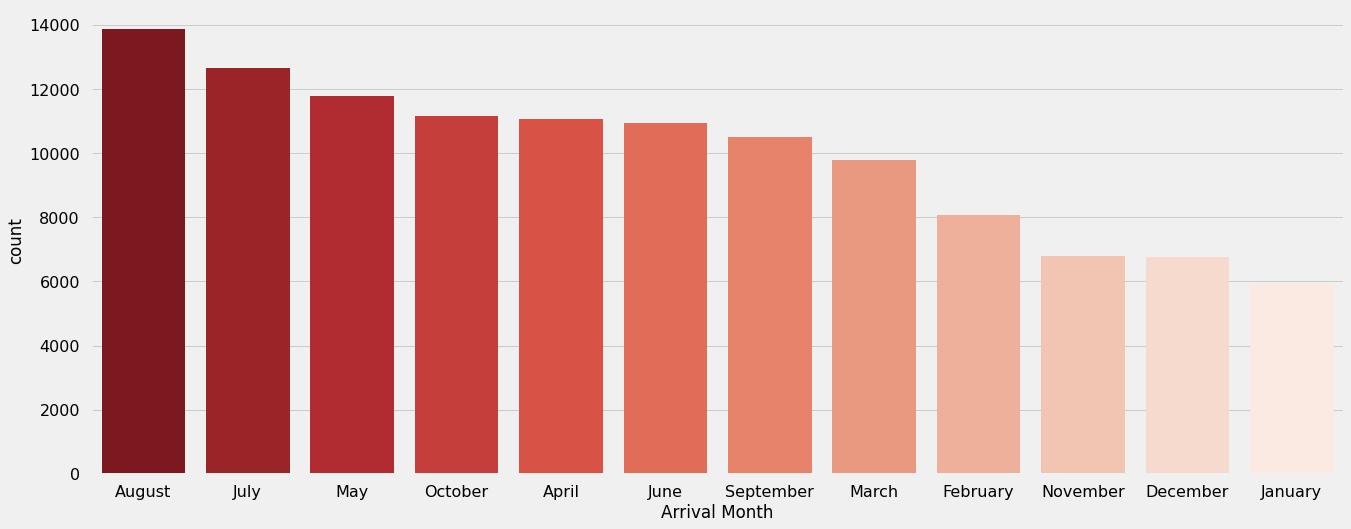

In [7]:
#Count plot of each month, ordered
plt.figure(figsize=(20,8))
sns.countplot(x='arrival_date_month', data=df, palette='Reds_r', order=df['arrival_date_month'].value_counts().index)
plt.xlabel('Arrival Month')
plt.show()

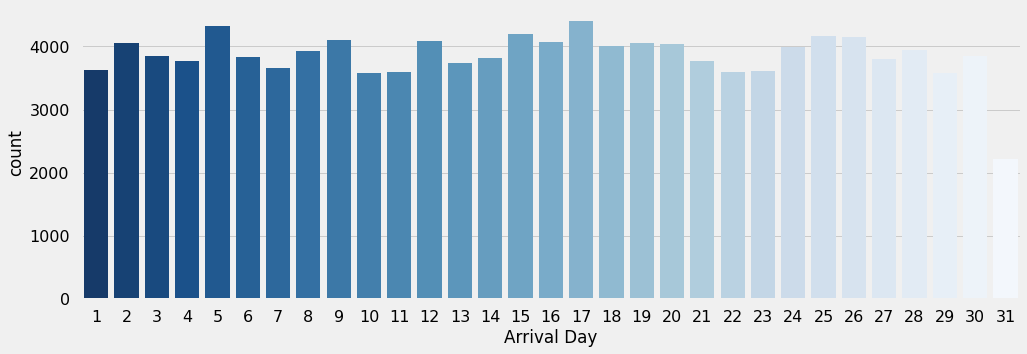

In [8]:
plt.figure(figsize=(15,5))
sns.countplot(x='arrival_date_day_of_month', data=df, palette='Blues_r')
plt.xlabel('Arrival Day')
plt.show()

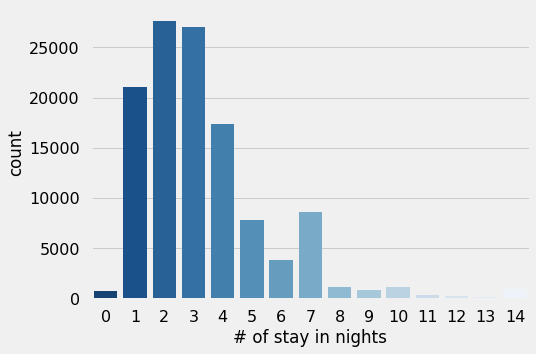

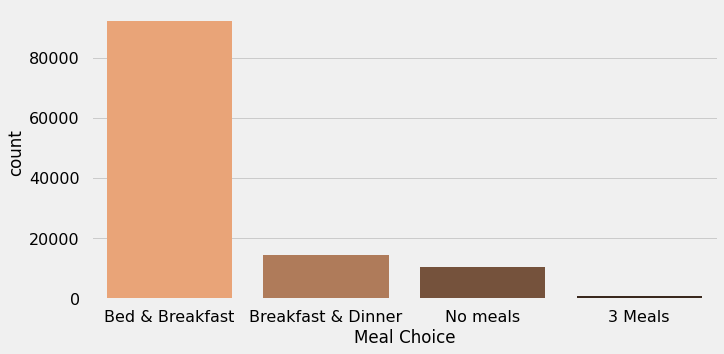

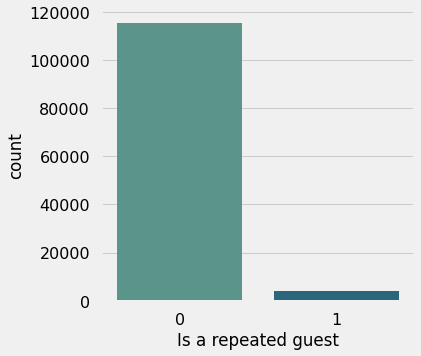

In [10]:
#Make countplot showcasing the number of week nights spent in the hotel

plt.figure(figsize=(7,5))
sns.countplot(x='stay_in_nights', data=df, palette='Blues_r', order=list(range(0, 15)))
plt.xlabel('# of stay in nights')
plt.show()

#Make countplot showcasing the most popular meals of the hotels

initial2meal = {'BB':'Bed & Breakfast', 'HB':'Breakfast & Dinner', 'SC':'No meals', 'FB':'3 Meals'} 
df['meal'] = df['meal'].map(initial2meal) #Change df['meal'] to be more descriptive

plt.figure(figsize=(10,5))
sns.countplot(x='meal', data=df, palette='copper_r', order=initial2meal.values())
plt.xlabel('Meal Choice')
plt.show()

df['meal'] = df['meal'].map({value: key for key, value in initial2meal.items()}) #Revert df['meal'] back to normal

#Make countplot showcasing the amount of repeated guests in hotels

plt.figure(figsize=(5,5))
sns.countplot(x='is_repeated_guest', data=df, palette='crest')
plt.xlabel('Is a repeated guest')
plt.show()

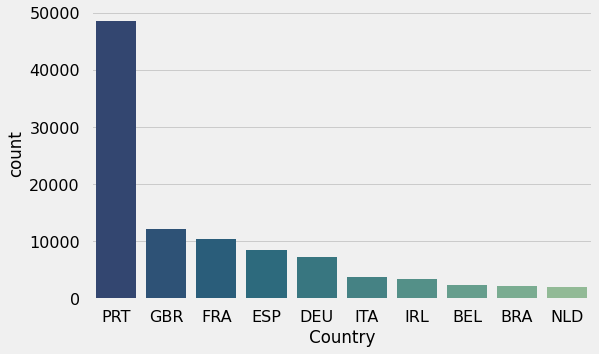

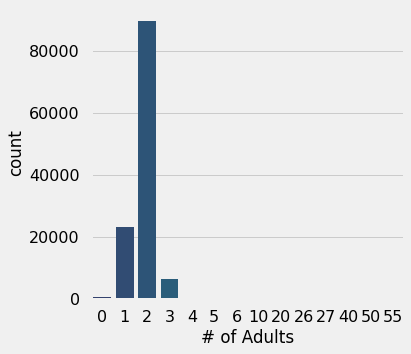

In [11]:
#Store the top 10 countries that are going into the hotels in top_10_country

x = {cont: len(df[df['country'] == cont]) for cont in np.unique(df['country'])}
country2count = dict(sorted(x.items(), key=lambda item: item[1]))
top_10_country = list(country2count.keys())[-10:]

#Show the top 10 countries in a countplot

plt.figure(figsize=(8,5))
sns.countplot(x='country', data=df, palette='crest_r', order=reversed(top_10_country))
plt.xlabel('Country')
plt.show()

#Show the amount of adults in the bookings

plt.figure(figsize=(5,5))
sns.countplot(x='adults', data=df, palette='crest_r')
plt.xlabel('# of Adults')
plt.show()

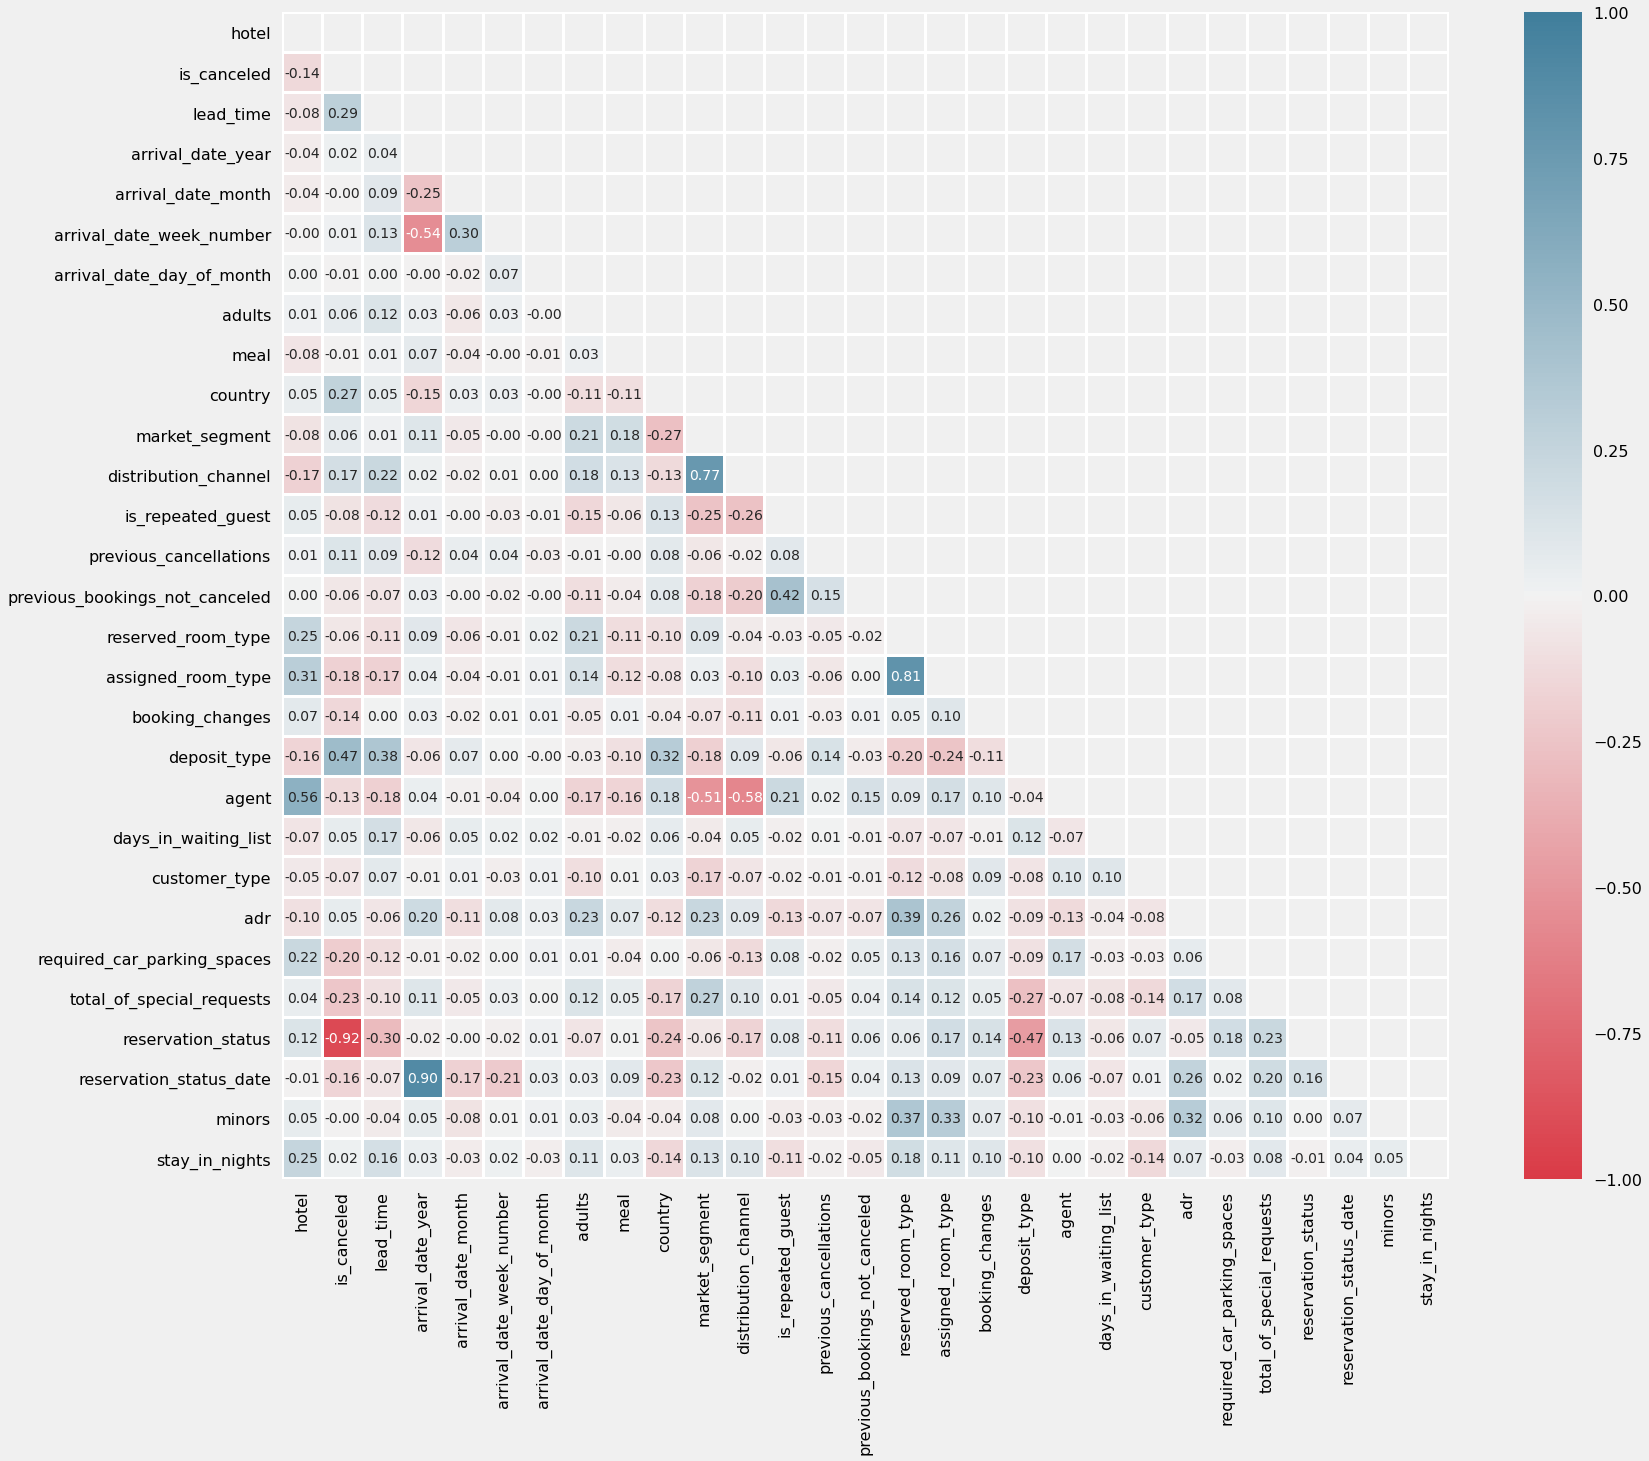

In [14]:
#Create correlation matrix

plt.figure(figsize=(24,20))
sns.heatmap(df_numeric.corr(), annot=True, cmap=sns.diverging_palette(10, 230, as_cmap=True), 
            square=True, linewidths=2, fmt=".2f", vmin=-1, vmax=1, mask=np.triu(np.ones((29,))))
plt.show()

Based on the correlation matrix, we can examine multiple pairs of unique correlated columns:

- is_canceled, deposit_type
- is_canceled, lead_time 
- is_canceled, total_of_special_requests
- assigned_room_type, reserved_room_type
- assigned_room_type, minors

These pairs of columns should be more closely analyzed to better understand how customers operate in hotels. 

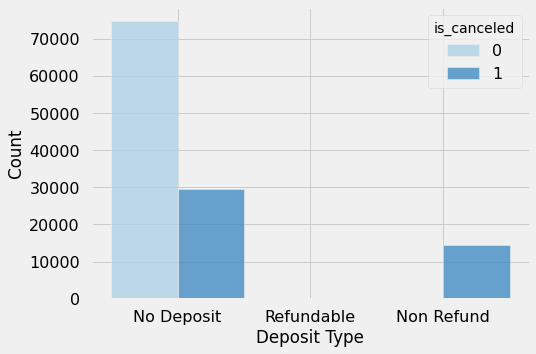

In [20]:
#Plot the relationship between the deposit type and the experimental probability of cancellation 

plt.figure(figsize=(7,5))
sns.histplot(x='deposit_type', hue='is_canceled', data=df, binwidth=1, multiple='dodge', palette='Blues')
plt.xlabel('Deposit Type')
plt.show()

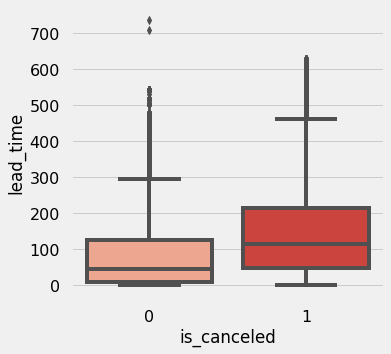

In [16]:
#Boxplot showcasing the relationship between cancellations and lead time

plt.figure(figsize=(5,5))
sns.boxplot(x='is_canceled', y='lead_time', data=df, palette='Reds')
plt.show()

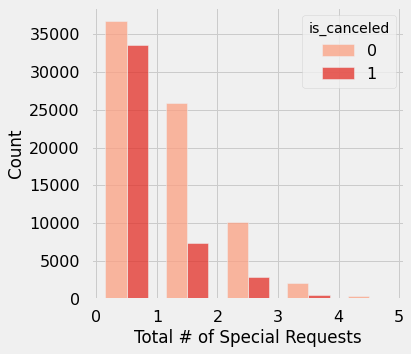

In [17]:
#Boxplot showcasing the relationship between cancellations and the total number of special requests

plt.figure(figsize=(5,5))
sns.histplot(x='total_of_special_requests', hue='is_canceled', data=df, binwidth=1, shrink=.7, multiple='dodge', palette='Reds')
plt.xlabel('Total # of Special Requests')
plt.show()

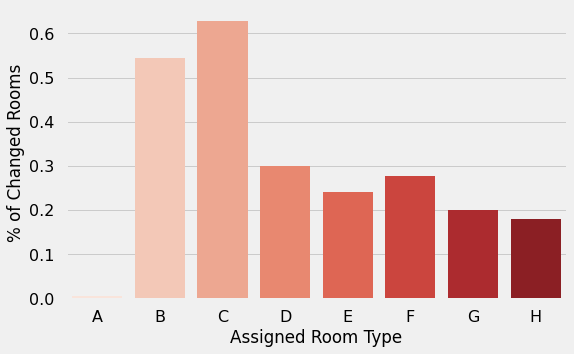

In [18]:
#Gather all types of rooms when assigned and compare them to the most common reserved room type

all_types = np.unique(df['assigned_room_type'])[:-4]

avg_change = [len(df[(df['assigned_room_type'] == typ) & (df['reserved_room_type'] != typ)]) /
              len(df[df['assigned_room_type'] == typ]['reserved_room_type']) for typ in all_types]

#Display the results using a bar plot

plt.figure(figsize=(8,5))
sns.barplot(x=all_types, y=avg_change, palette='Reds')
plt.xlabel('Assigned Room Type')
plt.ylabel('% of Changed Rooms')
plt.show()

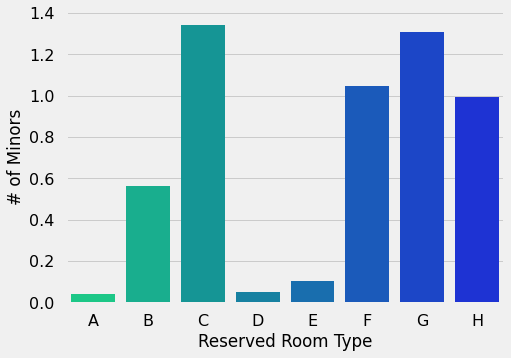

In [19]:
avg_minor = [np.mean(df[df['reserved_room_type'] == typ]['minors']) for typ in all_types]

plt.figure(figsize=(7,5))
sns.barplot(x=all_types, y=avg_minor, palette='winter_r')
plt.xlabel('Reserved Room Type')
plt.ylabel('# of Minors')
plt.show()

# Data Analysis Conclusion

Based on the Data Analysis on the hotel bookings, we can make a few conclusions:

1. Although not a majority, a substantial amount of bookings are cancelled 
2. Most hotel guests only visit once, stay multiple nights, and order only breakfast
3. The holidays do not appear to affect the amount of bookings to the hotel
4. Most hotel guests consist of 2 adults with no minors
4. The large majority of guests are Portugese
5. Guests with special requests tend to be less likely to cancel their bookings
6. Rooms B and C tend to be changed a lot from assigned to reserved.

So, in order to increase guest satisfaction, these hotels should focus on:

1. Improving their breakfasts
2. Shifting rooms to be more suitable for 2 adults with no minors
3. Assimilating their hotels more within Portugese culture
4. Investigating Rooms B and C to explore why they tend to be changed so much
5. Shifting their hotel to be more suitable as a stay-in rather than vacational

# Machine Learning

Now that basic EDA has been completed, we can begin making a Machine Learning Model that is capable of predicting the probability of a customer cancelling their bookings given information on what they booked. This model could be used by these hotels in order to gain prior knowledge of customers with a high chance of cancelling, and save valuable time. 

In [91]:
#Create function that can transform an input dataframe for ML

def preprocess_dataframe(input_df):
    
    #Remove unnecessary columns
    
    input_df = input_df.drop(['arrival_date_year', 'reserved_room_type', 'reservation_status', 'reservation_status_date'], 
                             axis=1)
    if 'company' in input_df.columns: 
        input_df = input_df.drop('company', axis=1)
    
    #Add in the columns 'minors' and 'stay_in_nights' if not already done
    
    if 'minors' not in input_df.columns and 'stay_in_nights' not in input_df.columns:
        
        input_df['children'] = input_df['children'].fillna(0)
        input_df['minors'] = input_df['children'] + input_df['babies']
        input_df = input_df.drop(['children', 'babies'], axis=1)

        input_df['stay_in_nights'] = input_df['stays_in_weekend_nights'] + input_df['stays_in_week_nights']
        input_df = input_df.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1)
        
    for col in input_df.columns:
        if input_df[col].dtype.name == 'object':
            input_df[col] = input_df[col].astype('category').cat.codes #Categorize categorical variables
        input_df[col] = np.sqrt(input_df[col])
    
    input_df = input_df.dropna()
    return input_df

#Store new dataframe in df_ML

df_ML = preprocess_dataframe(df.copy())
print(df_ML.isnull().sum())
print(len(df_ML))

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
adults                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
minors                            0
stay_in_nights                    0
dtype: int64
119389


C:\Users\14086\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
#Get X and y arrays from df_ML, and equalize the output(0 and 1)

df_ML = df_ML.sort_values('is_canceled')[30941:]
X = np.array(df_ML.drop('is_canceled', axis=1))
y = np.array(df_ML['is_canceled'])

print(list(y).count(0), list(y).count(1))

#Use Cross Validation to test how good Logistic Regression is

model = CatBoostClassifier(iterations=100)
scores = cross_val_score(model, X, y, cv=5)
print(scores.mean(), scores.std())

13283 44224
Learning rate set to 0.436467
0:	learn: 0.3311958	total: 170ms	remaining: 16.9s
1:	learn: 0.2741218	total: 179ms	remaining: 8.75s
2:	learn: 0.2332420	total: 187ms	remaining: 6.05s
3:	learn: 0.2173828	total: 195ms	remaining: 4.69s
4:	learn: 0.2093941	total: 203ms	remaining: 3.87s
5:	learn: 0.2035918	total: 212ms	remaining: 3.32s
6:	learn: 0.1989723	total: 219ms	remaining: 2.92s
7:	learn: 0.1889205	total: 228ms	remaining: 2.62s
8:	learn: 0.1842778	total: 236ms	remaining: 2.39s
9:	learn: 0.1822533	total: 244ms	remaining: 2.2s
10:	learn: 0.1775879	total: 252ms	remaining: 2.04s
11:	learn: 0.1742959	total: 261ms	remaining: 1.91s
12:	learn: 0.1721915	total: 269ms	remaining: 1.8s
13:	learn: 0.1698607	total: 277ms	remaining: 1.7s
14:	learn: 0.1677272	total: 284ms	remaining: 1.61s
15:	learn: 0.1640588	total: 290ms	remaining: 1.52s
16:	learn: 0.1621990	total: 297ms	remaining: 1.45s
17:	learn: 0.1584612	total: 305ms	remaining: 1.39s
18:	learn: 0.1573533	total: 312ms	remaining: 1.33s
19

66:	learn: 0.1309156	total: 536ms	remaining: 264ms
67:	learn: 0.1301666	total: 545ms	remaining: 256ms
68:	learn: 0.1295079	total: 552ms	remaining: 248ms
69:	learn: 0.1290482	total: 560ms	remaining: 240ms
70:	learn: 0.1284663	total: 567ms	remaining: 232ms
71:	learn: 0.1280164	total: 575ms	remaining: 223ms
72:	learn: 0.1275912	total: 582ms	remaining: 215ms
73:	learn: 0.1271377	total: 589ms	remaining: 207ms
74:	learn: 0.1266383	total: 596ms	remaining: 199ms
75:	learn: 0.1263145	total: 603ms	remaining: 191ms
76:	learn: 0.1257867	total: 610ms	remaining: 182ms
77:	learn: 0.1246632	total: 618ms	remaining: 174ms
78:	learn: 0.1240152	total: 625ms	remaining: 166ms
79:	learn: 0.1238318	total: 632ms	remaining: 158ms
80:	learn: 0.1234021	total: 639ms	remaining: 150ms
81:	learn: 0.1230973	total: 647ms	remaining: 142ms
82:	learn: 0.1227174	total: 655ms	remaining: 134ms
83:	learn: 0.1222962	total: 662ms	remaining: 126ms
84:	learn: 0.1215624	total: 670ms	remaining: 118ms
85:	learn: 0.1210918	total: 679

43:	learn: 0.0796955	total: 372ms	remaining: 473ms
44:	learn: 0.0787920	total: 386ms	remaining: 472ms
45:	learn: 0.0784638	total: 399ms	remaining: 469ms
46:	learn: 0.0774438	total: 414ms	remaining: 466ms
47:	learn: 0.0768962	total: 424ms	remaining: 460ms
48:	learn: 0.0757407	total: 435ms	remaining: 452ms
49:	learn: 0.0754447	total: 444ms	remaining: 444ms
50:	learn: 0.0751434	total: 454ms	remaining: 436ms
51:	learn: 0.0743427	total: 463ms	remaining: 427ms
52:	learn: 0.0738001	total: 471ms	remaining: 418ms
53:	learn: 0.0734321	total: 479ms	remaining: 408ms
54:	learn: 0.0730230	total: 488ms	remaining: 399ms
55:	learn: 0.0725273	total: 497ms	remaining: 390ms
56:	learn: 0.0723744	total: 505ms	remaining: 381ms
57:	learn: 0.0721651	total: 514ms	remaining: 372ms
58:	learn: 0.0717138	total: 523ms	remaining: 363ms
59:	learn: 0.0711101	total: 531ms	remaining: 354ms
60:	learn: 0.0702685	total: 539ms	remaining: 345ms
61:	learn: 0.0699312	total: 547ms	remaining: 335ms
62:	learn: 0.0696260	total: 555

# Results

The results of a 68.5% accuracy determine that a Machine Learning model is not capable of being able to accurately predict whether or not a customer will cancel their visit. More data should be collected with more features before attempting another Machine Learning model, and the hotels should follow the advice from the Data Analysis Conclusion.